In [64]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import csv
from tqdm import tqdm
import pandas as pd

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

In [65]:
output_dir = os.path.join(".", "output_bw_sac")  # Path to the output directory
subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
subdirs.sort()

# Create an empty 3D array to store the combined data
combined_arr = np.empty((len(subdirs), 1000, 10))

# Loop through each subdirectory and load the CSV files
for i, subdir in enumerate(subdirs):
    action_filename = os.path.join(subdir, "action.csv")
    obs_filename = os.path.join(subdir, "obs.csv")

    # Load the action and obs CSV files
    action_df = pd.read_csv(action_filename,  header=None)
    obs_df = pd.read_csv(obs_filename,  header=None)

    # Concatenate the DataFrames horizontally
    combined_data = pd.concat([action_df, obs_df], axis=1)

    # Convert combined_data to a 3D array and assign it to combined_arr
    combined_arr[i-1] = np.reshape(combined_data.values, (1000, 10))

# Print the shape of combined_arr
print(combined_arr.shape)
combined_tensor = torch.from_numpy(combined_arr)

(10000, 1000, 10)


# VAE code -1

====> Epoch: 1 Average loss: 0.010815005506787982, Recon Loss: 0.004414354460580009, KL Div: 0.03200325407300677
====> Epoch: 2 Average loss: 0.009741516385759626, Recon Loss: 0.004414002248219081, KL Div: 0.026637569972446987
====> Epoch: 3 Average loss: 0.009151845966066633, Recon Loss: 0.004413420268467494, KL Div: 0.02369212797709874
====> Epoch: 4 Average loss: 0.008676312310355051, Recon Loss: 0.004412556307656424, KL Div: 0.021318779809134346
====> Epoch: 5 Average loss: 0.008337566307612829, Recon Loss: 0.004411479234695434, KL Div: 0.01963043485369001
====> Epoch: 6 Average loss: 0.008130981172834124, Recon Loss: 0.004410242557525635, KL Div: 0.018603692531585694
====> Epoch: 7 Average loss: 0.00796821928024292, Recon Loss: 0.0044090609209878106, KL Div: 0.017795791898454937
====> Epoch: 8 Average loss: 0.007672246251787458, Recon Loss: 0.0044077884129115515, KL Div: 0.016322288376944407
====> Epoch: 9 Average loss: 0.0074553143978118895, Recon Loss: 0.004406333344323295, KL D

====> Epoch: 73 Average loss: 0.005081770828792027, Recon Loss: 0.0041132287638528005, KL Div: 0.004842710256576538
====> Epoch: 74 Average loss: 0.005057229621069772, Recon Loss: 0.0041047777788979665, KL Div: 0.004762259040560041
====> Epoch: 75 Average loss: 0.005026464870997838, Recon Loss: 0.004089986937386649, KL Div: 0.004682389514786857
====> Epoch: 76 Average loss: 0.004999812909535, Recon Loss: 0.00407917526790074, KL Div: 0.004603188344410487
====> Epoch: 77 Average loss: 0.004974087715148926, Recon Loss: 0.004069173472268241, KL Div: 0.0045245716231209895
====> Epoch: 78 Average loss: 0.0049469886847904754, Recon Loss: 0.004057654006140572, KL Div: 0.004446673444339207
====> Epoch: 79 Average loss: 0.0049193358761923656, Recon Loss: 0.004045475653239659, KL Div: 0.004369301114763533
====> Epoch: 80 Average loss: 0.004890624897820609, Recon Loss: 0.004032118371554784, KL Div: 0.004292532341820853
====> Epoch: 81 Average loss: 0.004862962654658726, Recon Loss: 0.0040196455546

====> Epoch: 144 Average loss: 0.003385902626173837, Recon Loss: 0.0031982687030519758, KL Div: 0.0009381697263036456
====> Epoch: 145 Average loss: 0.003363256743976048, Recon Loss: 0.003181302513395037, KL Div: 0.0009097712295395988
====> Epoch: 146 Average loss: 0.0033595846039908275, Recon Loss: 0.0031831556218011037, KL Div: 0.0008821450897625514
====> Epoch: 147 Average loss: 0.0033409010682787215, Recon Loss: 0.0031699044874736243, KL Div: 0.0008549830828394209
====> Epoch: 148 Average loss: 0.0033301964146750314, Recon Loss: 0.0031645124299185617, KL Div: 0.0008284198386328561
====> Epoch: 149 Average loss: 0.0033063623564583916, Recon Loss: 0.0031458424500056675, KL Div: 0.000802599378994533
====> Epoch: 150 Average loss: 0.003287600346973964, Recon Loss: 0.0031321242707116263, KL Div: 0.0007773803387369428
====> Epoch: 151 Average loss: 0.003289905343736921, Recon Loss: 0.003139374579702105, KL Div: 0.0007526538201740809
====> Epoch: 152 Average loss: 0.003275584237916129, Re

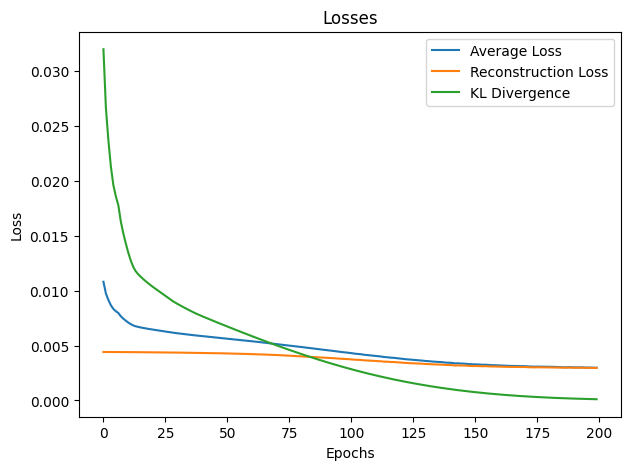

In [66]:
class Encoder(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, latent_dim * 2)  # mean and variance
        )

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        return mu, log_var, h


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_shape):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, output_shape),
        )

    def forward(self, z):
        x_reconstructed = self.decoder(z)
        return x_reconstructed


class VAE(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, input_shape)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var, h = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var

    
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

# Assuming combined_tensor is your data
# Convert the data to float32
dataset = TensorDataset(combined_tensor.float())

# Define the data loader
batch_size = 512  # adjust as necessary

# Split data into train, validation, and test
train_size = int(0.7 * len(dataset))  # 70% for training
valid_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - valid_size  # 15% for testing

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Hyperparameters
# input_shape = combined_tensor.shape[1] * combined_tensor.shape[2]  # modify this to match your data
# hidden_dim1 = 128  # modify as needed
# hidden_dim2 = 64  # modify as needed
# hidden_dim3 = 24  # modify as needed
# latent_dim = 2  # modify as needed
# lr = 5e-5  # learning rate
# n_epochs = 200  # modify as needed
# beta = 0.2
input_shape = combined_tensor.shape[1] * combined_tensor.shape[2]  # modify this to match your data
hidden_dim1 = 24  # modify as needed
hidden_dim2 = 12  # modify as needed
hidden_dim3 = 12  # modify as needed
latent_dim = 2  # modify as needed
lr = 5e-5  # learning rate
n_epochs = 200  # modify as needed
beta = 0.2
    
    
# Model, optimizer, and loss function
model = VAE(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)

optimizer = optim.RAdam(model.parameters(), lr=lr)  # Make sure you're using the correct optimizer
loss_fn = nn.MSELoss()  # And the correct loss function


def train(epoch, model, optimizer, loss_fn, train_loader):
    model.train()
    train_loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    for i, batch in enumerate(train_loader):  # using train_loader instead of dataloader
        batch_data = batch[0]  # get the data from the batch
        
        optimizer.zero_grad()

        # Flatten the data
        batch_data = batch_data.view(batch_data.size(0), -1)

        reconstructed_batch, mu, log_var = model(batch_data)

        # Loss: reconstruction loss + KL divergence
        recon_loss = loss_fn(reconstructed_batch, batch_data)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + beta*kl_divergence

        loss.backward()
        train_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_div += kl_divergence.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_div = total_kl_div / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss}, Recon Loss: {avg_recon_loss}, KL Div: {avg_kl_div}')

    return avg_loss, avg_recon_loss, avg_kl_div

    
import matplotlib.pyplot as plt

# Lists to store losses for each epoch
avg_losses = []
avg_recon_losses = []
avg_kl_divs = []

# Training
for epoch in range(1, n_epochs + 1):
    avg_loss, avg_recon_loss, avg_kl_div = train(epoch, model, optimizer, loss_fn, train_loader)
    avg_losses.append(avg_loss)
    avg_recon_losses.append(avg_recon_loss)
    avg_kl_divs.append(avg_kl_div)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(avg_losses, label='Average Loss')
plt.plot(avg_recon_losses, label='Reconstruction Loss')
plt.plot(avg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
def evaluate(model, loss_fn, dataloader):
    model.eval()
    loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            batch_data = batch[0]  # get the data from the batch

            # Flatten the data
            batch_data = batch_data.view(batch_data.size(0), -1)

            reconstructed_batch, mu, log_var = model(batch_data)

            # Loss: reconstruction loss + KL divergence
            recon_loss = loss_fn(reconstructed_batch, batch_data)
            kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss += recon_loss + kl_divergence
            total_recon_loss += recon_loss.item()
            total_kl_div += kl_divergence.item()

    avg_loss = loss / len(dataloader.dataset)
    avg_recon_loss = total_recon_loss / len(dataloader.dataset)
    avg_kl_div = total_kl_div / len(dataloader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_div
evaluate(model, loss_fn, test_loader)

# latent space plot

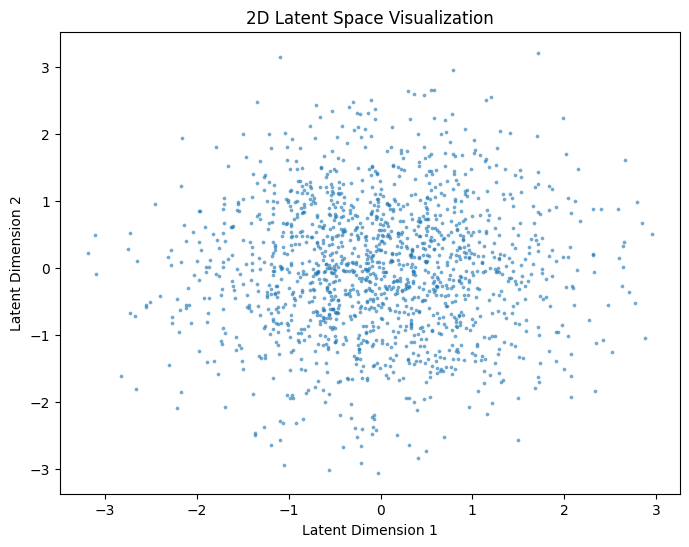

In [7]:
import numpy as np

# Get latent space representations for all data points
latent_vectors = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        mu, log_var,h  = model.encoder(batch_data)
        z = model.reparameterize(mu, log_var)
        latent_vectors.append(z)

dance_latent_vectors = torch.cat(latent_vectors, dim=0).numpy()

# Plot the data in 2D latent space
plt.figure(figsize=(8, 6))
plt.scatter(dance_latent_vectors[:, 0], dance_latent_vectors[:, 1], alpha=0.5, s=3)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Visualization')
plt.show()


In [ ]:
with torch.no_grad():
    for batch in test_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        mu, log_var = model.encoder(batch_data)
        print("mu is ", mu)
        print("log_var is ", log_var)

/var/folders/dl/61k_wctj56gfxw96rry1rsgw0000gn/T/ipykernel_41431/1674009495.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_z[:, 0], all_z[:, 1], cmap='tab10')


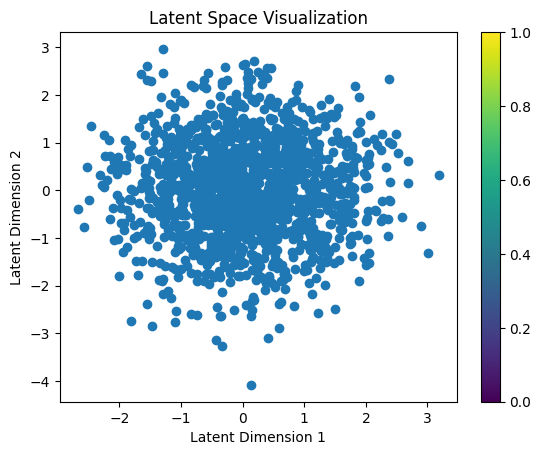

In [9]:
def plot_latent(vae, data_loader, num_batches=100):
    vae.eval()  # Set the VAE model to evaluation mode
    all_z = []

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            x = batch[0].view(batch[0].size(0), -1)  # Flatten the data

            mu, log_var,h = vae.encoder(x)
            z = vae.reparameterize(mu, log_var)

            all_z.append(z)

            if i >= num_batches:
                break

    all_z = torch.cat(all_z, dim=0).cpu().numpy()

    plt.scatter(all_z[:, 0], all_z[:, 1], cmap='tab10')
    plt.colorbar()
    plt.title('Latent Space Visualization')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()


plot_latent(model, test_loader)

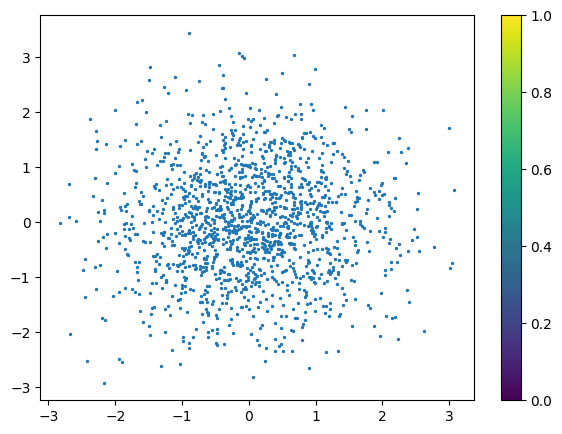

In [10]:
def plot_latent(model, data_loader):
    # Set the model to evaluation mode
    model.eval()
    latents = []
    for i, batch in enumerate(data_loader):
        x = batch[0]  # Get only the data (ignore the label)
        x = x.view(x.size(0), -1)
        mu, log_var,h = model.encoder(x)
        z = model.reparameterize(mu, log_var)
        latents.append(z.detach().cpu().numpy())
    latents = np.concatenate(latents, axis=0)
    plt.figure(figsize=(7,5))
    plt.scatter(latents[:, 0], latents[:, 1], s=2)
    plt.colorbar()
    plt.show()

# Call the function to plot latent representations
plot_latent(model, test_loader)


# render with action

In [48]:

import torch

# Convert combined_arr to PyTorch Tensor
# combined_tensor = torch.from_numpy(combined_arr)

# Print the shape of combined_tensor
print(combined_tensor.shape)

import matplotlib.pyplot as plt
from IPython import display
import gym


def replay(combined_data):

    action_sp = combined_data.iloc[:, :2]
    obs_sp = combined_data.iloc[:, 2:]

    env = gym.make('Swimmer-v3', render_mode = 'human')

    # Iterate through the rows
    for i in range(len(action_sp)):
        # Get the i-th row
        action = action_sp.iloc[i]
        observation = obs_sp.iloc[i]
#         print(action)

        # If this is the first iteration, set the environment state to the given observation
        # Note: This assumes that the observation you've stored is the entire state that can be set with `env.reset()`
        # If this is not the case, you cannot simply set the environment state to the observation
        if i == 0:
            env.reset()  # We ignore the initial observation returned by `reset`

        # Apply the action
        next_observation, reward, done, trunc, info = env.step(action)
        # Render the environment
        env.render()
        # If you want to slow down each step for viewing, you can use time.sleep
        # time.sleep(0.01)

    # Close the environment
    env.close()


torch.Size([10000, 1000, 10])


# render with action save

In [49]:
from gym import wrappers
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def replay_save(combined_data):
    action_sp = combined_data.iloc[:, :2]
    obs_sp = combined_data.iloc[:, 2:]

    env = gym.make('Swimmer-v3', render_mode = 'human')
    outputvid_dir = os.path.join(".", "video", "video.mp4")
    print(outputvid_dir)
    vid_recorder = VideoRecorder(env=env, path=outputvid_dir ,enabled=True)
#     vid_recorder = VideoRecorder(env, path=outputvid_dir) # Video file path
    
    # Iterate through the rows
    for i in range(len(action_sp)):
        action = action_sp.iloc[i]
        observation = obs_sp.iloc[i]

        if i == 0:
            env.reset()

        # Apply the action
        next_observation, reward, done, trunc, info = env.step(action)
        
        # Render the environment
        env.render()

        # Capture frame for video
        vid_recorder.capture_frame()
#         print('video saved')

    # Close the environment and video recorder
    vid_recorder.close()
    env.close()

# see the output

In [67]:
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            batch_data = batch[0]  # get the data from the batch
            batch_data = batch_data.view(batch_data.size(0), -1)  # flatten the data
            reconstructed_batch, _, _ = model(batch_data)  # get reconstructed data from the model

            # Convert tensors to numpy arrays for use in pandas
            original_data = batch_data.detach().cpu().numpy()
            reconstructed_data = reconstructed_batch.detach().cpu().numpy()

            # Convert to dataframes
            original_df = pd.DataFrame(original_data)
            reconstructed_df = pd.DataFrame(reconstructed_data)

            if i == 0:  # for the first iteration, create the dataframes
                all_original_df = original_df
                all_reconstructed_df = reconstructed_df
            else:  # for subsequent iterations, append to the existing dataframes
                all_original_df = pd.concat([all_original_df, original_df])
                all_reconstructed_df = pd.concat([all_reconstructed_df, reconstructed_df])
    
    return all_original_df, all_reconstructed_df

# Call the function after training
original_df, reconstructed_df = test_model(model, test_loader)


In [34]:
original_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,1.0,-0.799911,0.642990,0.095921,-0.199597,-0.245471,1.392302,-0.779271,1.252861,-1.209755,...,0.955820,1.000000,0.633161,-0.022027,0.094778,-0.241823,0.191086,0.045887,0.010494,-0.003329
1,1.0,-1.000000,0.608437,0.040464,-0.120313,-0.190196,1.333062,-0.806154,1.363885,-1.381985,...,1.000000,1.000000,0.618608,0.018600,-0.079007,-0.295066,0.172379,-0.015458,-0.037163,0.035230
2,1.0,-0.811637,0.778924,0.101289,-0.240432,-0.399889,1.322550,-0.823261,1.238321,-1.222184,...,0.037832,1.000000,0.648455,0.000380,-0.018812,-0.148528,0.135858,0.053848,-0.016507,0.029685
3,1.0,-0.868363,0.686848,0.219878,-0.028251,-0.290843,1.389916,-0.806420,1.288554,-1.250539,...,0.390160,1.000000,0.845406,0.141429,-0.150936,-0.280377,0.070875,0.003842,-0.035850,-0.025931
4,1.0,-0.902580,0.618521,0.127263,-0.155294,-0.205063,1.303244,-0.817633,1.342012,-1.278430,...,-1.000000,-0.542751,0.737315,0.030132,-0.042465,-0.143967,0.163696,0.024896,0.036125,0.005425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,1.0,-0.945316,0.794787,0.116681,-0.082196,-0.347163,1.383129,-0.844254,1.336963,-1.353468,...,1.000000,1.000000,0.673617,0.154765,-0.169396,-0.317128,0.160350,-0.023197,-0.023560,0.011479
472,1.0,-0.748563,0.793796,0.092141,-0.199910,-0.250349,1.339923,-0.807581,1.209579,-1.176969,...,0.797993,1.000000,0.672566,0.118468,-0.095796,-0.194611,0.147013,-0.003884,-0.007774,0.036591
473,1.0,-0.965466,0.716997,0.100950,-0.115049,-0.274592,1.351683,-0.848349,1.374089,-1.314847,...,0.954064,1.000000,0.699023,0.069668,-0.146691,-0.149212,0.115359,0.026452,0.019045,0.009720
474,1.0,-0.948783,0.705261,0.065200,-0.120561,-0.186816,1.365440,-0.874889,1.313953,-1.294596,...,0.766894,1.000000,0.598695,0.064915,-0.168329,-0.265765,0.144248,-0.041530,0.014105,-0.035585


In [35]:
reconstructed_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.806556,-0.758845,0.541834,0.126675,-0.139809,-0.237897,1.108133,-0.646475,0.993374,-0.964529,...,0.279351,0.521878,0.611553,0.048428,-0.052221,-0.258992,0.119761,0.005987,-0.004741,0.004175
1,0.768178,-0.774983,0.510486,0.118042,-0.168987,-0.219371,1.140852,-0.723608,1.013162,-1.036681,...,0.245828,0.546591,0.610755,0.024128,-0.069849,-0.219557,0.108657,-0.002937,0.003215,-0.007178
2,0.905297,-0.773943,0.589306,0.145906,-0.124564,-0.237178,1.203905,-0.688711,1.079824,-1.039416,...,0.301369,0.562379,0.686418,0.055201,-0.035631,-0.263731,0.122714,0.018979,-0.000478,0.007155
3,0.819170,-0.757523,0.546291,0.133864,-0.141258,-0.233835,1.140573,-0.670542,1.014484,-0.996044,...,0.280586,0.528204,0.632579,0.048073,-0.050253,-0.255578,0.123292,0.011158,-0.000867,0.006700
4,1.236479,-0.875668,0.792131,0.155567,-0.082939,-0.263217,1.444075,-0.801860,1.269243,-1.158713,...,0.369141,0.689326,0.811037,0.102829,0.027567,-0.304360,0.145173,0.033378,-0.008964,0.012728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,0.951948,-0.871081,0.638996,0.103953,-0.176424,-0.259038,1.254408,-0.762109,1.122942,-1.059911,...,0.304516,0.658081,0.682342,0.039036,-0.067436,-0.258286,0.116123,-0.020057,-0.030061,-0.019293
472,1.061016,-0.885933,0.722980,0.125144,-0.147107,-0.262115,1.344289,-0.786851,1.170263,-1.105498,...,0.345128,0.667804,0.742828,0.067771,-0.039133,-0.286794,0.148109,-0.005006,-0.024124,-0.006497
473,0.989408,-0.783893,0.629707,0.151463,-0.112152,-0.256903,1.243808,-0.675314,1.116255,-1.025905,...,0.325900,0.586565,0.702664,0.070637,-0.023806,-0.282223,0.128937,0.021294,-0.005975,0.016824
474,0.798956,-0.750656,0.532942,0.138647,-0.144387,-0.221271,1.151875,-0.694168,1.017103,-1.028066,...,0.269853,0.522673,0.637211,0.041434,-0.051747,-0.241666,0.124037,0.014093,0.007213,0.007158


In [68]:
# Get the first row from the dataframe
first_row_reco = reconstructed_df.iloc[0]

# Reshape it to (1000, 10)
reshaped_reco_array = np.reshape(first_row_reco.values, (1000, 10))

# Convert it back to a dataframe
reshaped_df_reco = pd.DataFrame(reshaped_reco_array)
recon_combined_tensor = torch.tensor(reshaped_df_reco.values)


In [45]:
replay(reshaped_df_reco)

/opt/homebrew/Caskroom/miniconda/base/envs/firstenv/lib/python3.11/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Swimmer-v3 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/firstenv/lib/python3.11/site-packages/gym/envs/mujoco/mujoco_env.py:190: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(


Creating window glfw


/opt/homebrew/Caskroom/miniconda/base/envs/firstenv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
2023-08-10 18:11:32.716 python[41431:10797410] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


In [ ]:
replay_save(reshaped_df_reco)

In [69]:
# Get the first row from the dataframe
first_row_ori = original_df.iloc[0]

# Reshape it to (1000, 10)
reshaped_array_ori = np.reshape(first_row_ori.values, (1000, 10))

# Convert it back to a dataframe
reshaped_df_ori = pd.DataFrame(reshaped_array_ori)
ori_combined_tensor = torch.tensor(reshaped_df_ori.values)


In [ ]:
replay(reshaped_df_ori)

In [71]:
# Flatten the tensors
flattened_ori = ori_combined_tensor.flatten()
flattened_recon = recon_combined_tensor.flatten()

# Calculate the Euclidean distance
euclidean_distance = torch.norm(flattened_ori - flattened_recon)


print(euclidean_distance)


tensor(171.7844)


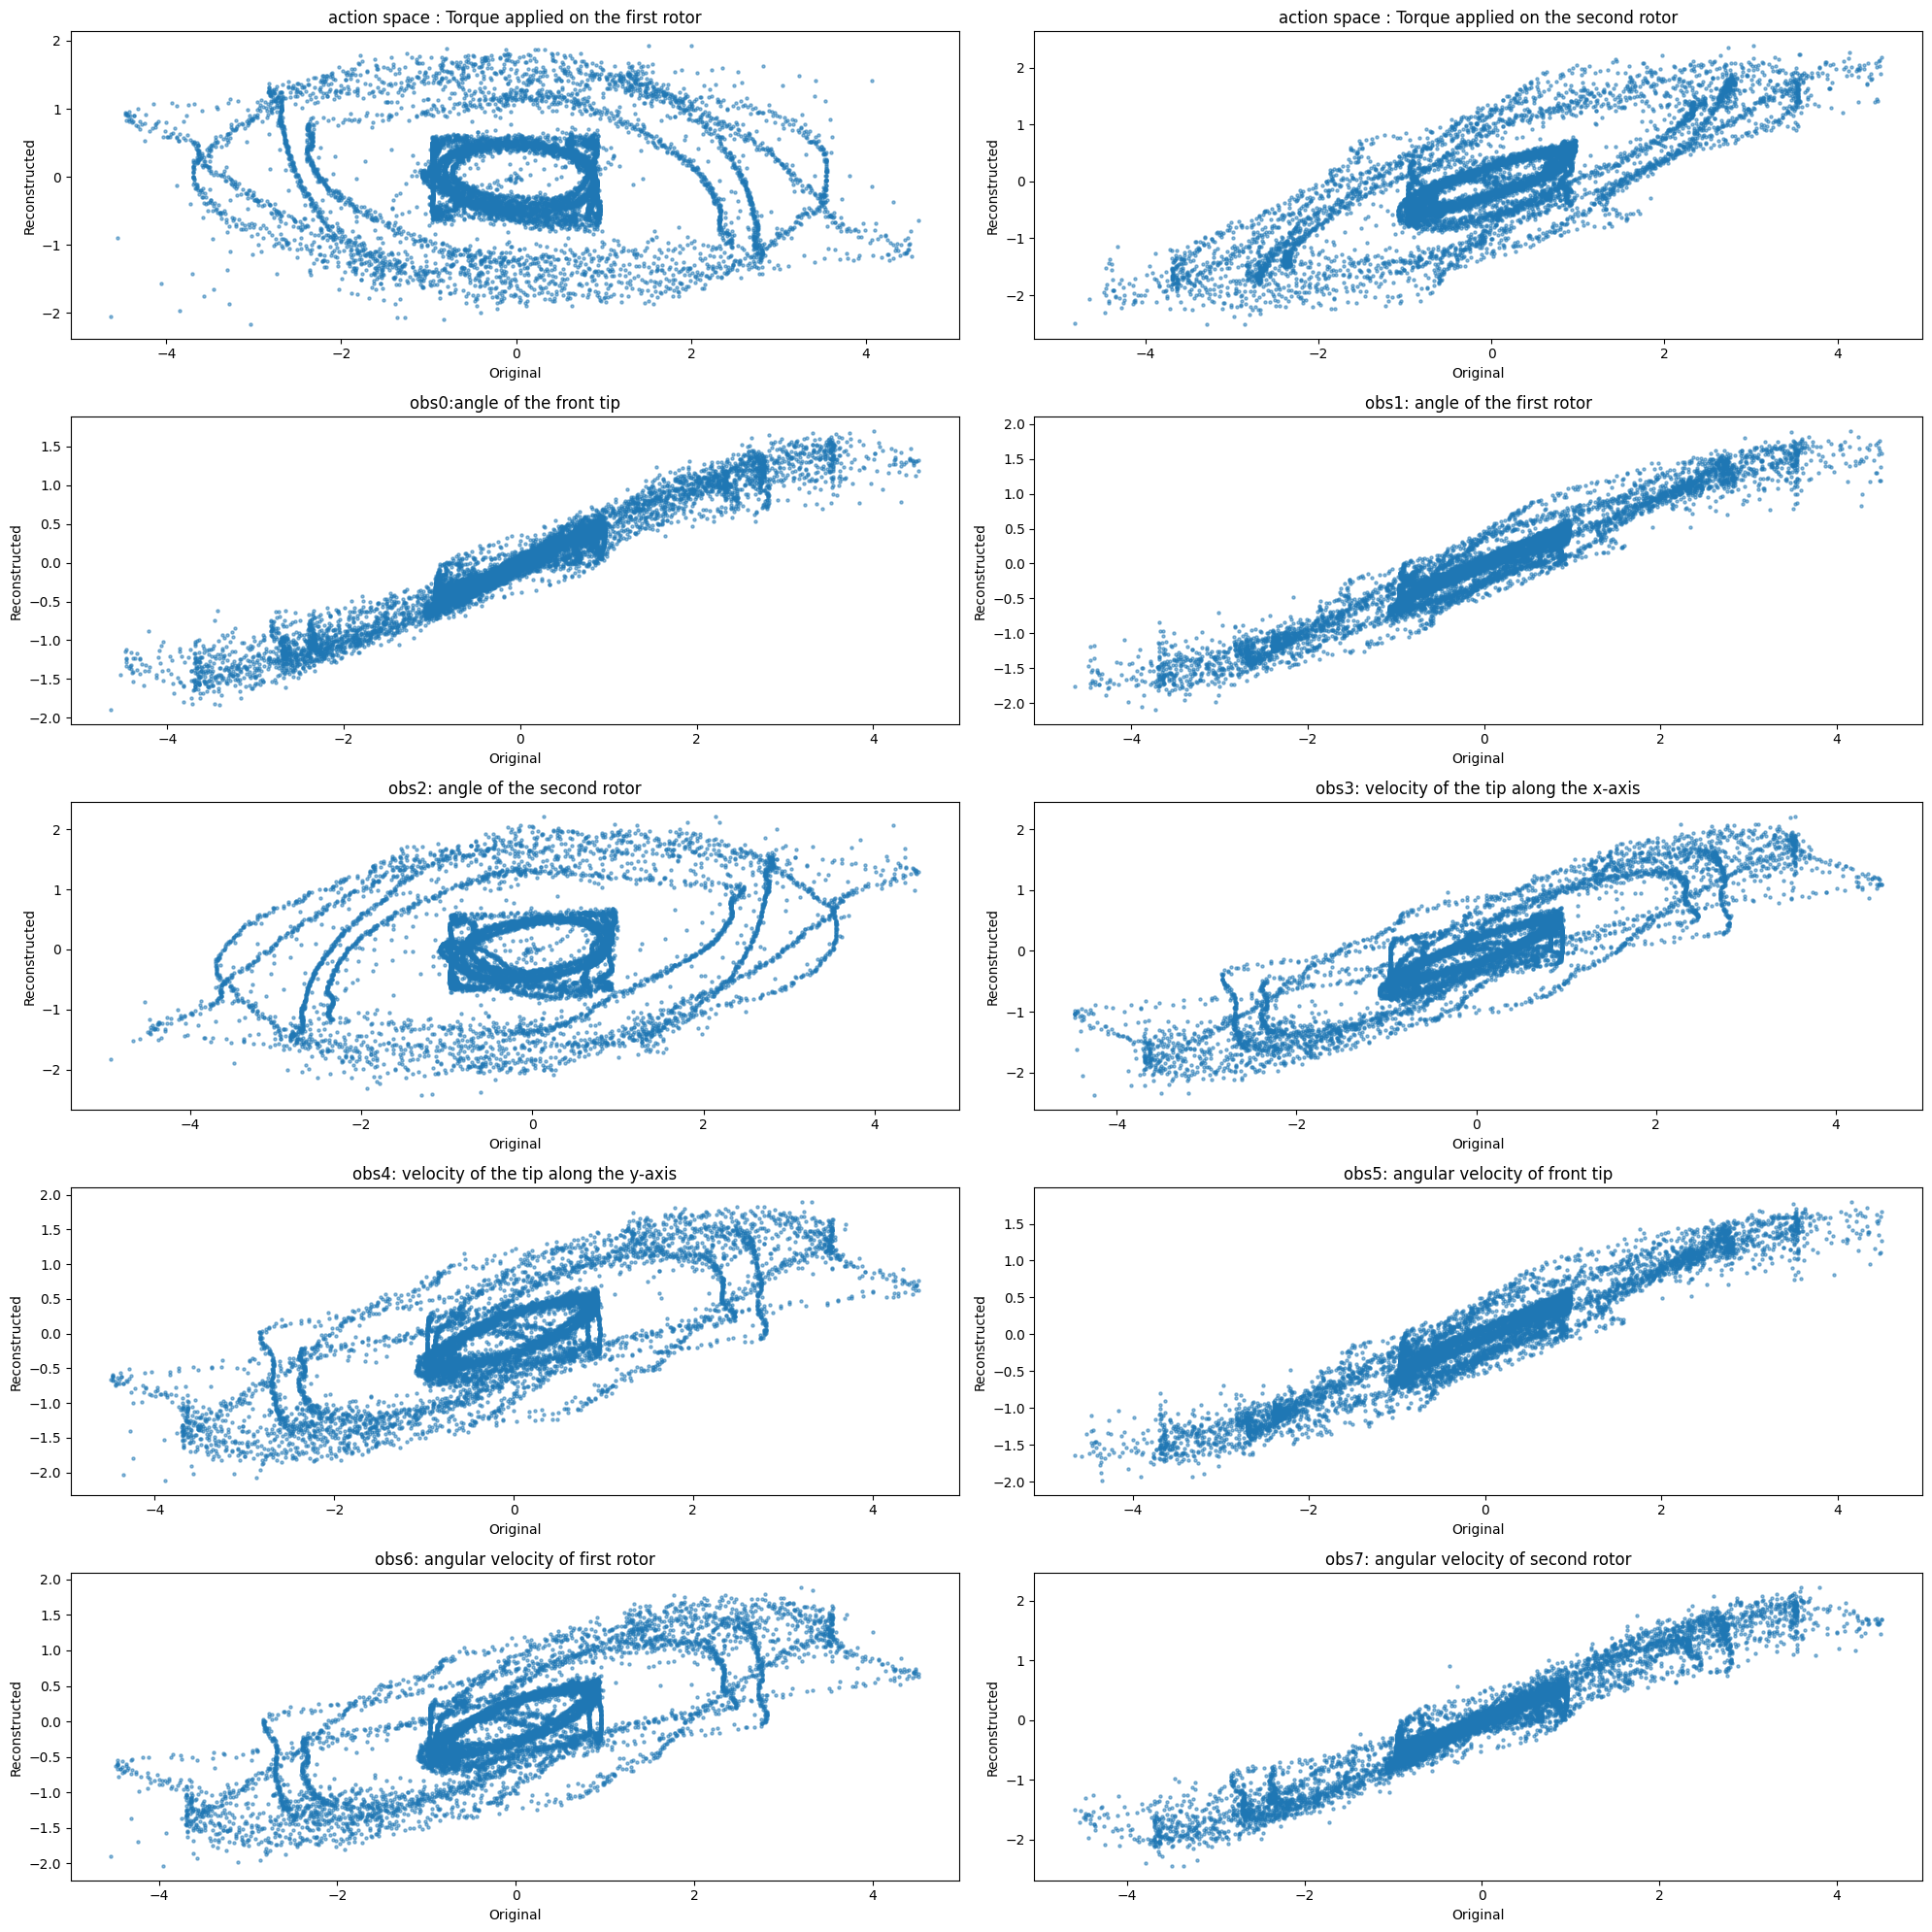

In [79]:
ori_combined_np = original_df.to_numpy()
recon_combined_np = reconstructed_df.to_numpy()

# Column names
column_names = ['action space : Torque applied on the first rotor', 
                'action space : Torque applied on the second rotor', 
                'obs0:angle of the front tip', 'obs1: angle of the first rotor', 
                'obs2: angle of the second rotor', 'obs3: velocity of the tip along the x-axis',
                'obs4: velocity of the tip along the y-axis', 'obs5: angular velocity of front tip',
                'obs6: angular velocity of first rotor', 'obs7: angular velocity of second rotor']

# Create a figure
plt.figure(figsize=(20, 20))

# Create subplots for each column
for i in range(10):  # Assuming you have 10 columns
    plt.subplot(5, 2, i+1)  # 5 rows and 2 columns of subplots
    plt.scatter(ori_combined_np[i, :], recon_combined_np[i, :], alpha=0.5, s=5)
    plt.title(column_names[i])
    plt.xlabel('Original')
    plt.ylabel('Reconstructed')

# Display the plot
plt.tight_layout()
plt.show()


In [75]:
ori_combined_np.shape

(1500, 10000)

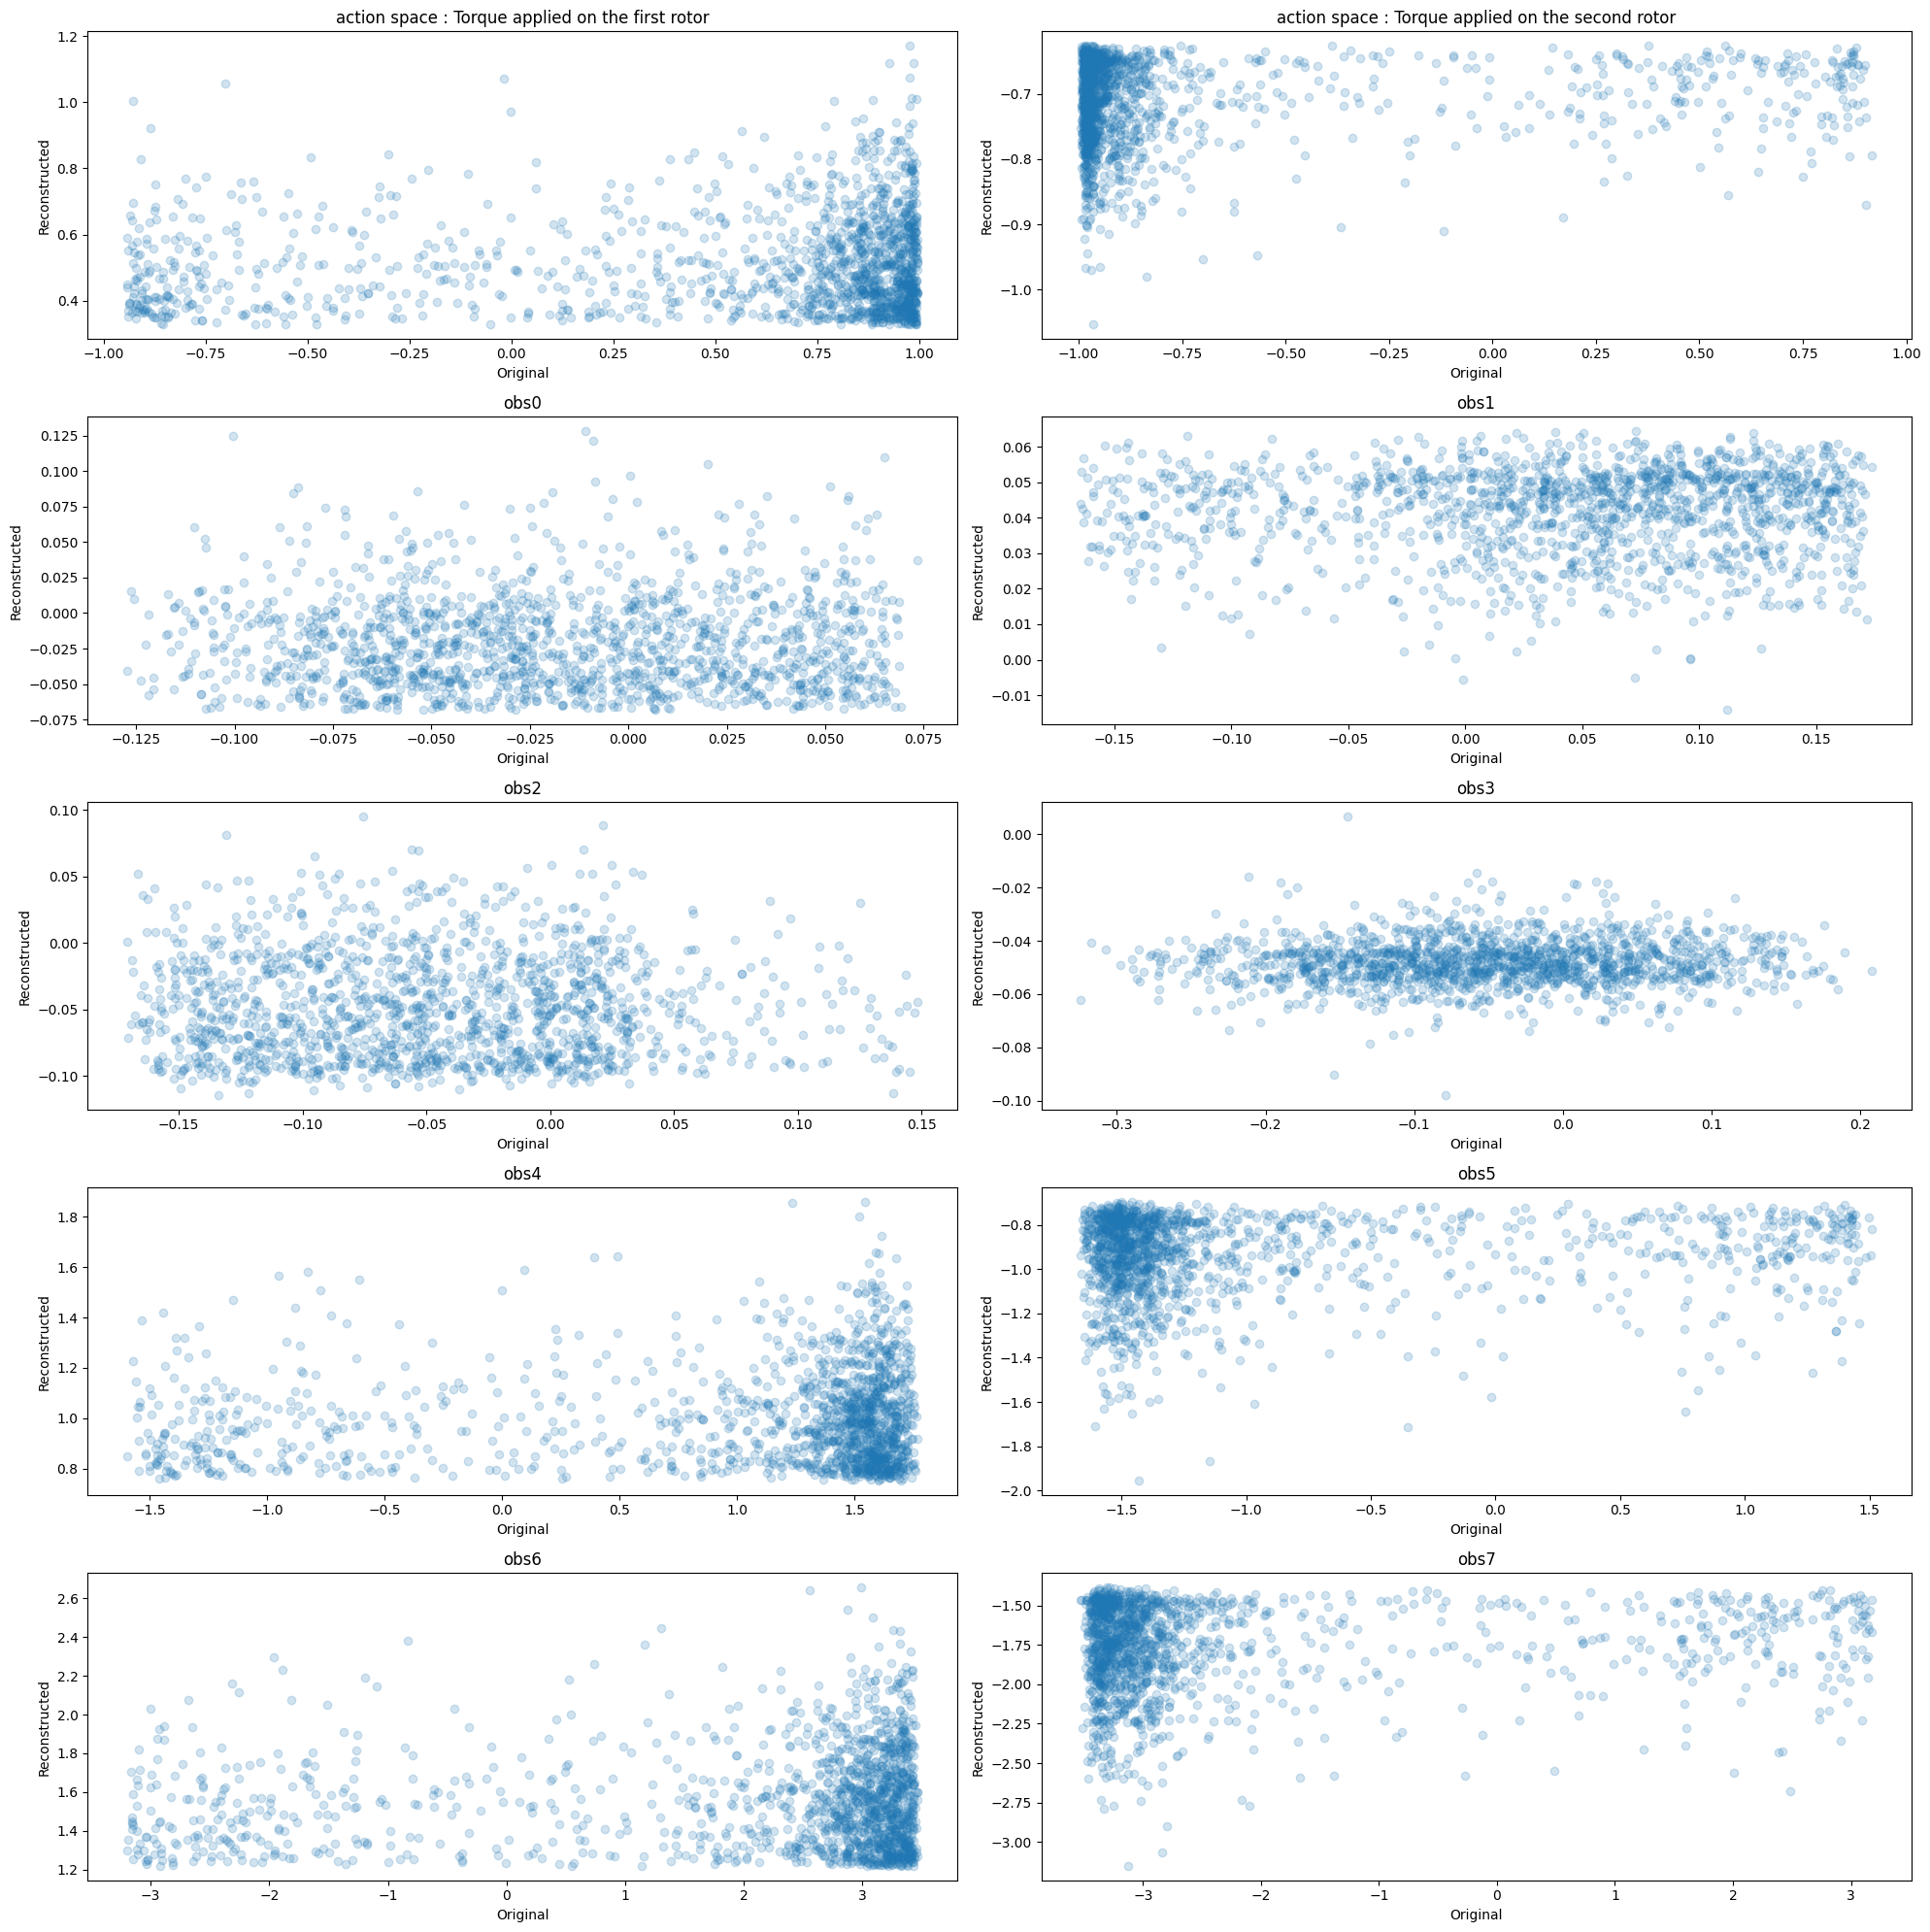

In [76]:
# Column names
column_names = ['action space : Torque applied on the first rotor', 
                'action space : Torque applied on the second rotor', 
                'obs0', 'obs1', 'obs2', 'obs3', 'obs4', 'obs5', 'obs6', 'obs7']

# Create a figure
plt.figure(figsize=(20, 20))

# Create subplots for each column
for i in range(10):  # Assuming you have 10 columns
    plt.subplot(5, 2, i+1)  # 5 rows and 2 columns of subplots
    plt.scatter(ori_combined_np[:, i], recon_combined_np[:, i], alpha=0.2)
    plt.title(column_names[i])
    plt.xlabel('Original')
    plt.ylabel('Reconstructed')

# Display the plot
plt.tight_layout()
plt.show()


In [77]:
# Test

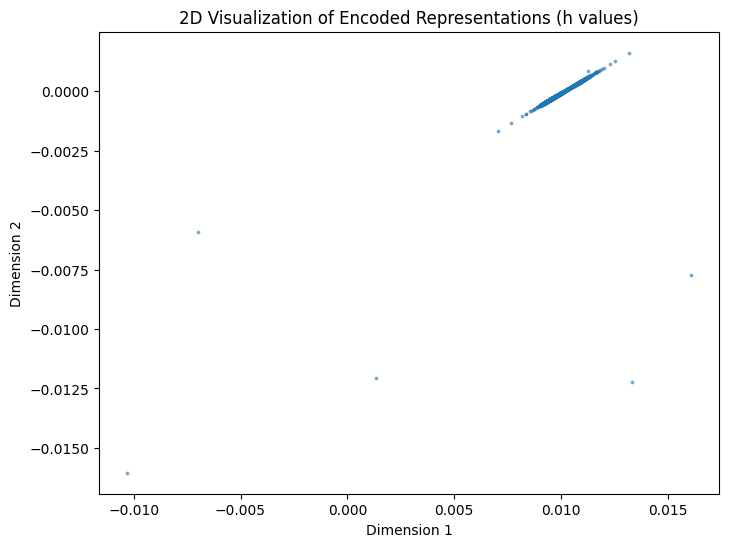

In [78]:
# Get encoded representations (h values) for all data points
encoded_representations = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        batch_data = batch_data.float()
        _, _, h = model.encoder(batch_data)  # Get the encoded representation (h value) directly
        encoded_representations.append(h)

encoded_representations = torch.cat(encoded_representations, dim=0).numpy()

# Assuming the encoded representations are 2D, plot the data in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(encoded_representations[:, 0], encoded_representations[:, 1], alpha=0.5, s=3)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Encoded Representations (h values)')
plt.show()
